In [0]:
# Mask R-CNN code
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 914 (delta 0), reused 0 (delta 0), pack-reused 913
Receiving objects: 100% (914/914), 112.91 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (538/538), done.


In [0]:
import os

In [0]:
os.chdir('Mask_RCNN')

In [0]:
!ls

assets	images	     mask_rcnn.egg-info  requirements.txt  setup.py
build	LICENSE      mrcnn		 samples
dist	MANIFEST.in  README.md		 setup.cfg


In [0]:
# Mask R-CNN dependencies
!pip3 install -r requirements.txt
!python setup.py install

# COCO tools
!pip3 install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
!pip3 install pycocotools

# Windowing backend
!pip3 install pyqt5

In [0]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
import io
from googleapiclient.http import MediaIoBaseDownload
import shutil

In [0]:
file_id = '1fMNCzJ9bWjzMT2trCgn-TvFLd-a5t0cC'
request = drive_service.files().get_media(fileId=file_id)
fh = io.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
fh.seek(0)
with open('bee_data.zip', 'wb') as f:
    shutil.copyfileobj(fh, f, length=131072)
fh = None
!ls

Download 100%.
assets	      dist     MANIFEST.in	   README.md	     setup.cfg
bee_data.zip  images   mask_rcnn.egg-info  requirements.txt  setup.py
build	      LICENSE  mrcnn		   samples


In [0]:
!unzip bee_data.zip

Archive:  bee_data.zip
   creating: bee_data/
  inflating: bee_data/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/bee_data/
  inflating: __MACOSX/bee_data/._.DS_Store  
  inflating: bee_data/readme.txt     
   creating: bee_data/train/
  inflating: bee_data/train/.DS_Store  
   creating: __MACOSX/bee_data/train/
  inflating: __MACOSX/bee_data/train/._.DS_Store  
   creating: bee_data/train/Annotations/
  inflating: bee_data/train/Annotations/.DS_Store  
   creating: __MACOSX/bee_data/train/Annotations/
  inflating: __MACOSX/bee_data/train/Annotations/._.DS_Store  
  inflating: bee_data/train/Annotations/1542047010993.xml  
  inflating: __MACOSX/bee_data/train/Annotations/._1542047010993.xml  
  inflating: bee_data/train/Annotations/1542047176282.xml  
  inflating: __MACOSX/bee_data/train/Annotations/._1542047176282.xml  
  inflating: bee_data/train/Annotations/1542047329410.xml  
  inflating: __MACOSX/bee_data/train/Annotations/._1542047329410.xml  
   creating: bee_data

In [0]:
import skimage.io
import skimage

In [0]:
image = skimage.io.imread('image3.jpg')
skimage.io.imshow(image)

In [0]:
import sys
import random
import math
import numpy as np
import cv2

import xml.etree.ElementTree

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

In [0]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

Using TensorFlow backend.


In [0]:
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

/usr/local/lib/python3.6/dist-packages/pycocotools/coco.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
    

https://stackoverflow.com/questions/1912434/how-do-i-parse-xml-in-python

In [0]:
class BeeDataset(utils.Dataset):

    def load_bee(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("bee", 1, "bee")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        image_dir = os.path.join(dataset_dir, "Images")
        annot_dir = os.path.join(dataset_dir, "Annotations")

        # do something for each xml file in annotation dir
        for file in os.listdir(annot_dir):

          path = os.path.join(annot_dir, file)

          if os.path.isfile(path) and file.endswith('.xml'):
            
            print(file)

            #assert file.endswith('.xml')
            
            # parse
            eTree = xml.etree.ElementTree.parse(path)
            root = eTree.getroot()

            # trust the hardcode, hope MIT label me does not change
            filename = root[0].text
            height = int(root[3][0].text)
            width = int(root[3][1].text)
            
            polygons = []

            # trust the hardcode, hope MIT label me does not change
            # the first four are metadata
            for obj in root[4:]:
              shape_attr = {
                  'all_points_x': [],
                  'all_points_y': []}
              # polygon is the last element, first one is metadata
              for point in obj[-1][1:]:
                shape_attr['all_points_x'].append(int(point[0].text))
                shape_attr['all_points_y'].append(int(point[1].text))
              polygons.append(shape_attr)

            self.add_image(
                "bee",
                image_id=filename,  # use file name as a unique image id
                path=os.path.join(image_dir, filename),
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "bee":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "bee":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [0]:
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# COCO Class names
class_names = ['BG', 'bee']

... done downloading pretrained model!


In [0]:
# Model Configuration Settings
class TrainConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + bee
    
    STEPS_PER_EPOCH = 4

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [0]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [0]:
# Training dataset
dataset_train = BeeDataset()
dataset_train.load_bee("bee_data", "train")
dataset_train.prepare()

1542047176282.xml
1542047329410.xml
1542047010993.xml


In [0]:
# Training dataset
dataset_val = BeeDataset()
dataset_val.load_bee("bee_data", "val")
dataset_val.prepare()

1542046143395.xml


In [0]:
#this is meant to train the final terminal layers
assert init_with == "coco"

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers=r"(mrcnn_class_logits)|(mrcnn_bbox_fc)|(mrcnn_bbox)|(mrcnn_mask)")


Starting at epoch 1. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/coco20181124T0506/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
In model:  rpn_model
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)
mrcnn_mask             (TimeDistributed)


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
4/4 [==============================] - 69s 17s/step - loss: 3.1471 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.3298 - mrcnn_class_loss: 0.5444 - mrcnn_bbox_loss: 1.3664 - mrcnn_mask_loss: 0.8888 - val_loss: 2.9444 - val_rpn_class_loss: 0.0346 - val_rpn_bbox_loss: 0.1355 - val_mrcnn_class_loss: 0.5572 - val_mrcnn_bbox_loss: 1.3343 - val_mrcnn_mask_loss: 0.8828


In [0]:
!ls logs/coco20181124T0506

events.out.tfevents.1543036260.79fb8a4b430d
events.out.tfevents.1543036326.79fb8a4b430d
events.out.tfevents.1543037395.79fb8a4b430d
events.out.tfevents.1543037434.79fb8a4b430d
mask_rcnn_coco_0001.h5
mask_rcnn_coco_0002.h5


In [0]:
!cat logs/coco20181124T0506

cat: logs/coco20181124T0506: Is a directory


In [0]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [0]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/Mask_RCNN/logs/coco20181124T0506/mask_rcnn_coco_0002.h5
Re-starting from epoch 2


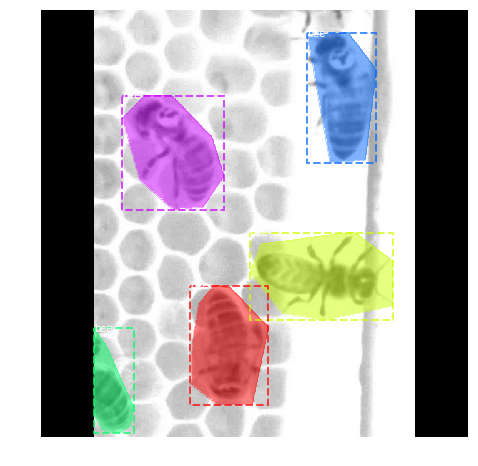

In [0]:
# Test on a random image
image_id = 0#"1542046143395.jpg"
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

#log("original_image", original_image)
#log("image_meta", image_meta)
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [0]:
dataset_val.image_info

[{'height': 811,
  'id': '1542046143395.jpg',
  'path': 'bee_data/val/Images/1542046143395.jpg',
  'polygons': [{'all_points_x': [407, 450, 517, 538, 484],
    'all_points_y': [49, 289, 283, 112, 41]},
   {'all_points_x': [55, 99, 150, 226, 248, 209, 152, 88],
    'all_points_y': [203, 160, 162, 241, 314, 373, 378, 322]},
   {'all_points_x': [318, 495, 570, 568, 440, 359, 297],
    'all_points_y': [443, 420, 476, 561, 588, 575, 498]},
   {'all_points_x': [233, 302, 333, 260, 229, 200, 189, 185],
    'all_points_y': [747, 748, 602, 526, 521, 557, 626, 709]},
   {'all_points_x': [0, 27, 54, 77, 70, 56, 33, 16, 11, 1],
    'all_points_y': [601, 640, 703, 752, 789, 800, 801, 797, 785, 768]}],
  'source': 'bee',
  'width': 611}]

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
import matplotlib
import matplotlib.pyplot as plt

Results of epoch 1 training on 4 images on the validation is below

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


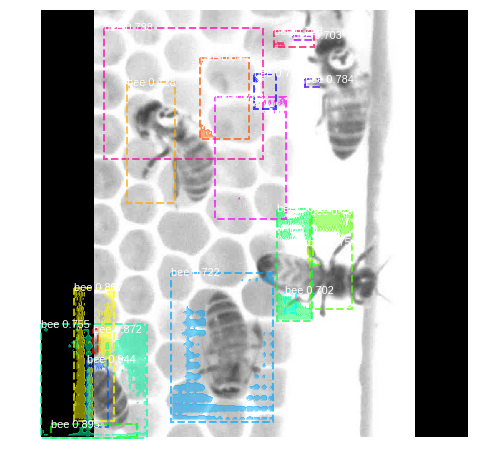

In [0]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Results of epoch 2 training on 4 images on the validation is below

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


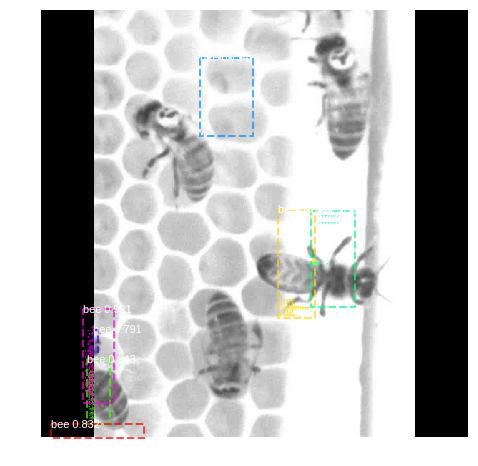

In [0]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Results of epoch 2 training on 4 images on a "trained" image is below

Processing 1 images
image                    shape: (718, 1103, 3)        min:   37.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1103.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


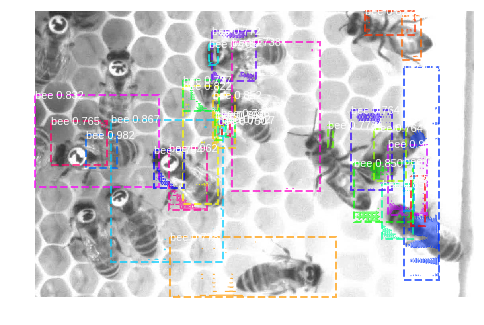

In [0]:
original_image = skimage.io.imread('bee_data/train/Images/1542047010993.jpg')
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [0]:
!ls

assets	      build   LICENSE	MANIFEST.in	    mrcnn	      samples
bee_data      dist    logs	mask_rcnn_coco.h5   README.md	      setup.cfg
bee_data.zip  images  __MACOSX	mask_rcnn.egg-info  requirements.txt  setup.py


download weights

In [0]:
from google.colab import files

In [0]:
files.download('logs/coco20181124T0506/mask_rcnn_coco_0002.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 44802, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil